In [49]:
! pip3 install opencv-python




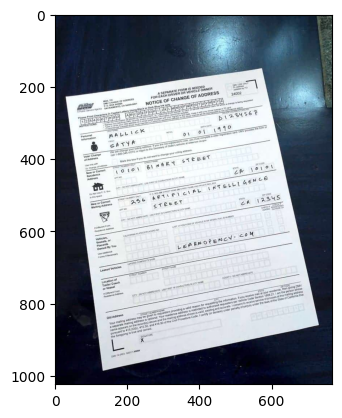

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread("test.jpg", cv2.IMREAD_COLOR)
plt.imshow(img)

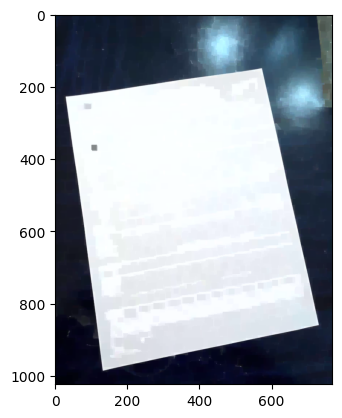

In [51]:
# Repeated Closing operation to remove text from the document.
kernel = np.ones((5, 5), np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)

plt.imshow(img)

## 3. The Magic of GrabCut in OpenCV Document Scanner
Once you have a blank document, the next step is to get rid of the background. We will use GrabCut to extract the foreground. 

It simply requires a bounding box around the object that is in the foreground, everything outside the bounding box is considered the background.  
GrabCut automatically rids you of all the background, even inside the bounding box. All you’re left with now is the foreground object. 
Having users manually draw these bounding boxes won’t really be very ‘automatic’. So, we take the corner 20 pixels as the background, and GrabCut automatically determines the foreground and background, leaving us only with the document.

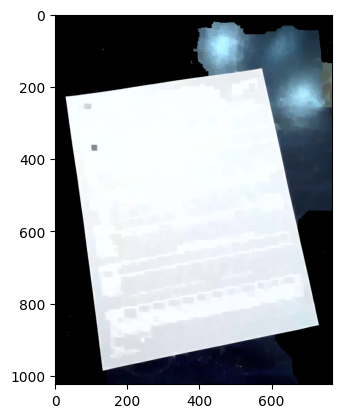

In [52]:
mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
img = img * mask2[:, :, np.newaxis]
plt.imshow(img)

## 4. Edge Detection and Contour Detection
Edge Detection
Now that you have a blank page with no background, you’re ready to perform edge detection. Use canny-edge detection to detect the edges of the document. The canny-edge detector can give the precise outline of the document. 

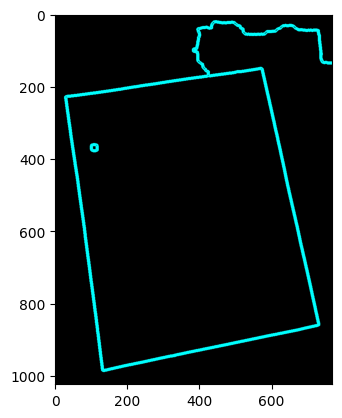

In [53]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))


# Blank canvas.
con = np.zeros_like(img)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

plt.imshow(con)

## 5. Detecting the Corner Points
Our end goal is to align the document, and for that, we need its four corners. Now that you have the contour for the edge, use ‘cv2.approxPolyDP’ to get the corner points. Using the Douglas-Peucker algorithm, this function approximates a curve or a polygon with another curve/polygon, with fewer vertices. 

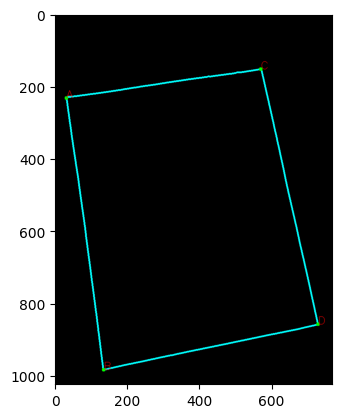

In [54]:
# Blank canvas.
con = np.zeros_like(img)
# Loop over the contours.
for c in page:
    # Approximate the contour.
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
    # If our approximated contour has four points
    if len(corners) == 4:
        break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())

# Displaying the corners.
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(
        con,
        character,
        tuple(c),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 0),
        1,
        cv2.LINE_AA,
    )

plt.imshow(con)